In [1]:
import numpy as np
import pandas as pd
import gc
from tqdm import *
import os
import copy
import sys
from collections import Counter, deque

import transforms3d

from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.cluster import MeanShift

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import ipyvolume as ipv
import open3d as o3d

import warnings
warnings.filterwarnings("ignore")

# %matplotlib inline


In [2]:
%matplotlib notebook

In [3]:
VOXEL_SZ = 1


# MAP_FILE = 'map_2019-02-26_ref_run_ccw_r.pcd'
# POSE_FILE = 'pose_2019-02-26_ref_run_ccw_r.json'

MAP_FILE = 'map_acc_template3_1.pcd'
POSE_FILE = 'pose_acc_template3_1.json'
X_GRID = np.arange(-3, 3.5, 0.5)
Y_GRID = np.arange(-3, 3.5, 0.5)
THETA_GRID = np.arange(-5, 6, 1)

In [4]:
def pose2matrix(translation_list, rotation_angle_list):
    trans_vec = np.array(translation_list)
    rot_ang = [np.deg2rad(ang) for ang in rotation_angle_list ]
    rot_mat = transforms3d.euler.euler2mat(rot_ang[0], rot_ang[1], rot_ang[2])
    zoom = np.ones(3)
    transform_mat = transforms3d.affines.compose(trans_vec, rot_mat, zoom)
    return transform_mat

def filter_pcd(old_pcd,
               apply_downsample = True,
               downsample_voxel_size = VOXEL_SZ,
               
               apply_outlier_removal = True,
               downsample_radius = 1,
               downsample_neighbors = 20,
               
               apply_crop = True,
               crop_min_arr = np.array([-100,-100,0]),
               crop_max_arr = np.array([100,100,100]),
               
               apply_cluster = True,
               cluster_neighbours = 30,
               cluster_labels = 2):
    np.random.seed(0)
    pcd = copy.deepcopy(old_pcd)
    
    if apply_downsample:
        voxel_down_pcd = o3d.geometry.voxel_down_sample(pcd, voxel_size = downsample_voxel_size)
        pcd = voxel_down_pcd

    if apply_outlier_removal:
        denser_pcd, ind = o3d.geometry.radius_outlier_removal(pcd,
                                                              nb_points = downsample_neighbors,
                                                              radius    = downsample_radius)
        pcd = denser_pcd
    
    if apply_crop:
        cropped_pcd = o3d.geometry.crop_point_cloud(pcd, crop_min_arr, crop_max_arr)
        pcd = cropped_pcd

    if apply_cluster:
        few_pts = np.asarray(pcd.points)
        try:
            few_pts_reduced = LocallyLinearEmbedding(n_neighbors=cluster_neighbours, n_components=2).fit_transform(few_pts)
        except Exception as e:
            try:
                few_pts_reduced = LocallyLinearEmbedding(n_neighbors=cluster_neighbours, n_components=2, eigen_solver='dense').fit_transform(few_pts)
            except Exception as e:
                few_pts_reduced = few_pts
        clf = MeanShift().fit(few_pts_reduced)
        pcd.points = o3d.utility.Vector3dVector(few_pts[clf.labels_ < cluster_labels])
    
    return pcd

def read_pcd(pcd_id):
    pcd_file = str(pcd_id) + ".pcd"
    pcd = o3d.io.read_point_cloud(os.path.join(LIDAR_PCD_PATH, pcd_file))
    return pcd

def draw_pcd(pcd, where='mat_3d'):
    if where is 'opn_nb':
        visualizer = o3d.JVisualizer()
        visualizer.add_geometry(pcd)
        visualizer.show()
    elif where is 'opn_view':
        o3d.visualization.draw_geometries([pcd], width=1280, height=800)
    elif where is 'mat_3d':
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1], pts[:,2])
        plt.show()
    elif where is 'mat_2d':
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1], s=0.5)
        plt.show()
        
def draw_registration_result(src_pcd, dst_pcd, x_pt, y_pt, theta):    
    src_pcd_tmp = copy.deepcopy(src_pcd)
    dst_pcd_tmp = copy.deepcopy(dst_pcd)
    
    src_pcd_tmp.paint_uniform_color([1, 0, 0])  # red source
    dst_pcd_tmp.paint_uniform_color([0, 0, 1])  # blue target
    
    transform_mat = pose2matrix([x_pt, y_pt, 0], [0,0,theta])
    dst_pcd_tmp.transform(transform_mat)
    
    visualizer = o3d.JVisualizer()
    visualizer.add_geometry(src_pcd_tmp)
    visualizer.add_geometry(dst_pcd_tmp)
    visualizer.show()
#     o3d.visualization.draw_geometries([source_temp, target_temp])

In [5]:
map_pcd = o3d.io.read_point_cloud(MAP_FILE)

In [6]:
map_pcd

geometry::PointCloud with 3002 points.

<IPython.core.display.Javascript object>


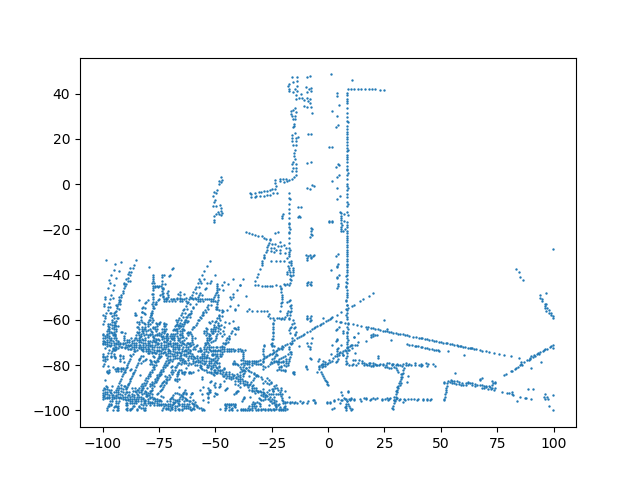

In [7]:
# draw_pcd(map_pcd)
plt.figure()
draw_pcd(map_pcd, where='mat_2d')

In [8]:
draw_pcd(map_pcd, where='opn_nb')

JVisualizer with 1 geometries

In [9]:
df_pose = pd.read_json(POSE_FILE, lines=True)[800:870]

<IPython.core.display.Javascript object>


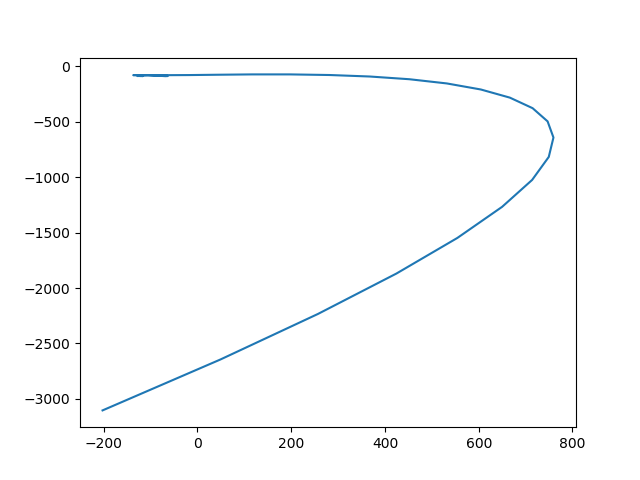

In [10]:
plt.figure()
plt.plot(df_pose['x'], df_pose['y'])

<IPython.core.display.Javascript object>


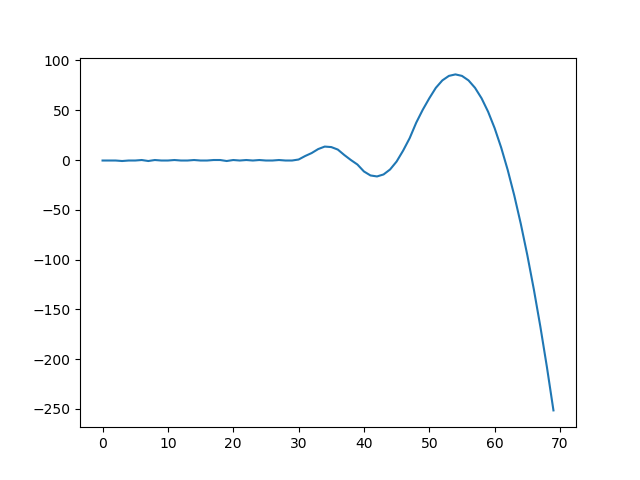

In [11]:
plt.figure()
plt.plot(range(df_pose.shape[0]), df_pose['x_vel'])

<IPython.core.display.Javascript object>


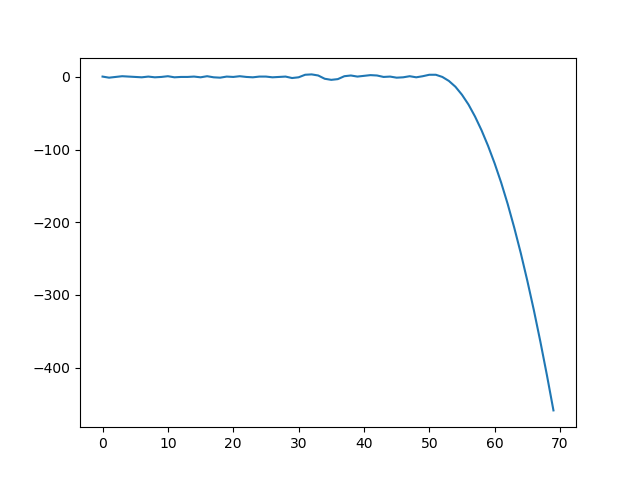

In [12]:
plt.figure()
plt.plot(range(df_pose.shape[0]), df_pose['y_vel'])

<IPython.core.display.Javascript object>


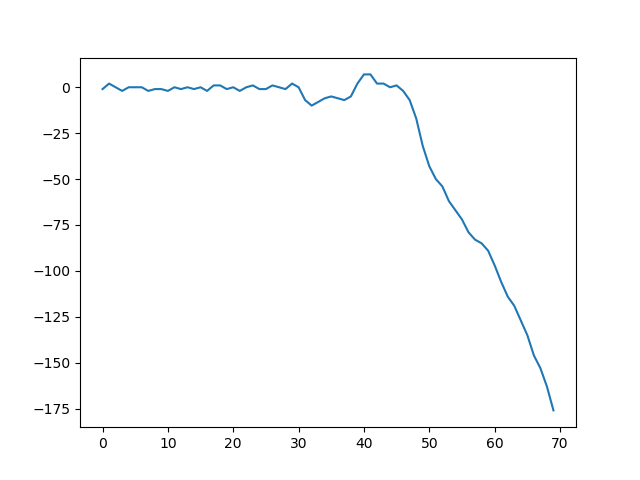

In [13]:
plt.figure()
plt.plot(range(df_pose.shape[0]), df_pose['theta_vel'])

<IPython.core.display.Javascript object>


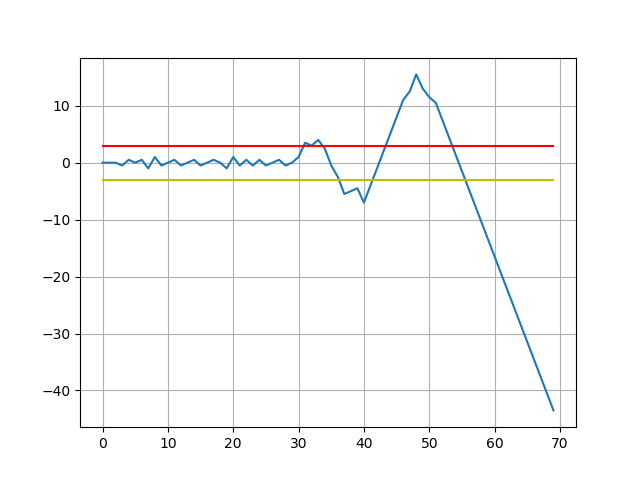

In [14]:
plt.figure()
plt.grid()
plt.plot(range(df_pose.shape[0]), df_pose['x_acc'])
plt.plot(range(df_pose.shape[0]), np.ones(df_pose.shape[0])*X_GRID[0], c='y')
plt.plot(range(df_pose.shape[0]), np.ones(df_pose.shape[0])*X_GRID[-1], c='r')

<IPython.core.display.Javascript object>


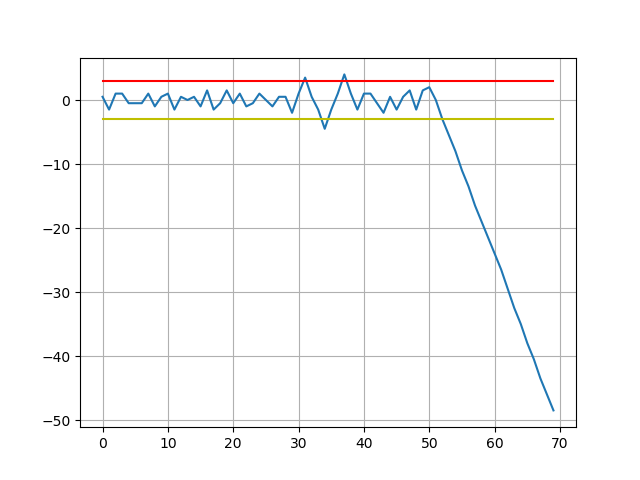

In [15]:
plt.figure()
plt.grid()
plt.plot(range(df_pose.shape[0]), df_pose['y_acc'])
plt.plot(range(df_pose.shape[0]), np.ones(df_pose.shape[0])*Y_GRID[0], c='y')
plt.plot(range(df_pose.shape[0]), np.ones(df_pose.shape[0])*Y_GRID[-1], c='r')

<IPython.core.display.Javascript object>


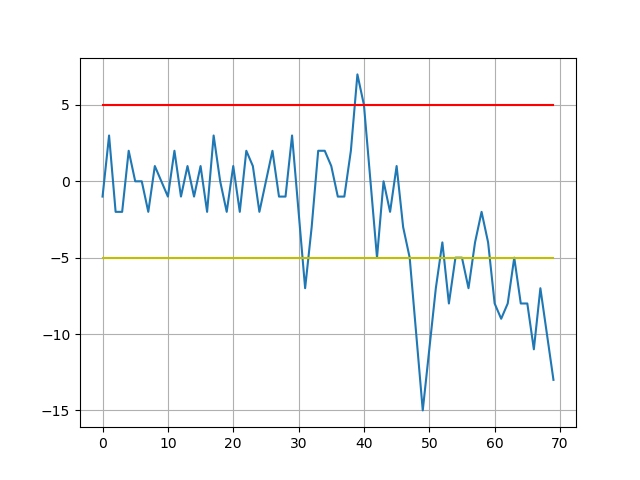

In [16]:
plt.figure()
plt.grid()
plt.plot(range(df_pose.shape[0]), df_pose['theta_acc'])
plt.plot(range(df_pose.shape[0]), np.ones(df_pose.shape[0])*THETA_GRID[0], c='y')
plt.plot(range(df_pose.shape[0]), np.ones(df_pose.shape[0])*THETA_GRID[-1], c='r')

In [20]:
# df_gt = pd.read_csv("/home/sabyasachi/Projects/ati/data/data/datasets/Carla/currentDataforCVPR/template3/static/1/groundTruth.csv")
df_gt = pd.read_csv("/home/sabyasachi/Projects/ati/data/data/datasets/Carla/currentDataForCPPR2/static/1/groundTruth.csv")

In [24]:
df_gt['acceleration_y'].max()

12.63757038116455

<IPython.core.display.Javascript object>


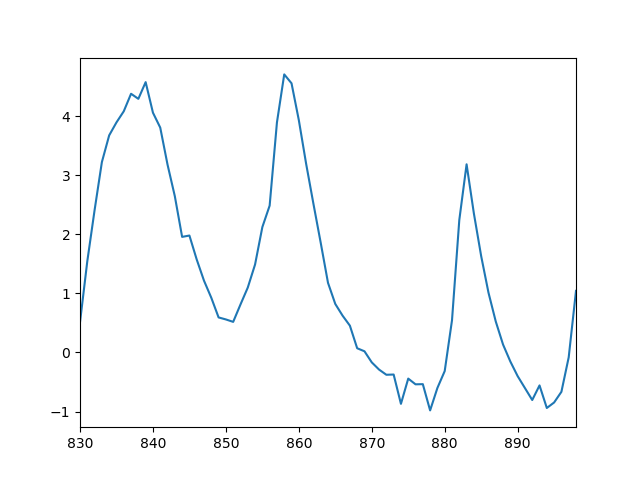

In [18]:
plt.figure()
df_gt[(df_gt['step'] > 830) & (df_gt['step'] < 900)]['acceleration_x'].plot()

<IPython.core.display.Javascript object>


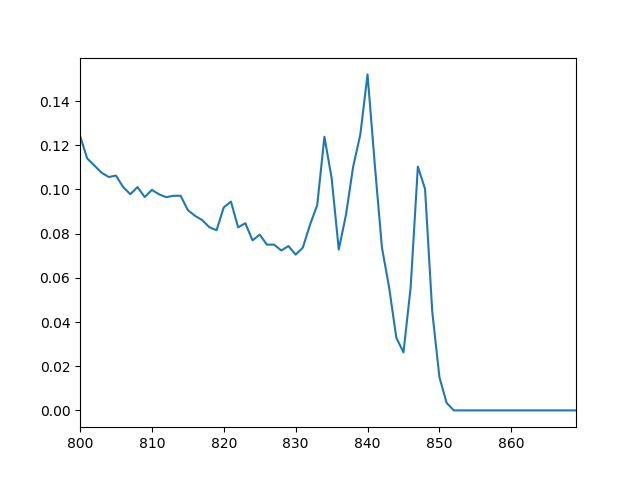

In [19]:
plt.figure()
df_pose['fit'].plot()